### README
**notes:**
first initial idea is to take failed PRs, feed their contexts into LLM using prompt and then ask it what it thinks the failure cause could be. The prompt used some predefined labels but we can tweak these to fit to predefined chosen labels with proper backing or reasoning behind.

total 33,000 PRs, I did like 50 just to see if the workflow works. Then because I dont have an OpenAI API key, I manually prompted for 5 context files and then their json outputs. Simple graph shows what labels were chosen for the 5 PRs and then a cross language visual that just shows what the languages were (not very helpful at the moment).

i noticed the 5 PRs I chose, and the rest of the 50 as well, there aren't first failing CI snippets or top review comments for almost all of them. This then leads the LLM to respond that there isn't sufficient context to pinpoint the problem and thus, outputs its guessed cause with low confidence. Need to see how we can work around this.

Also haven't looked at chains of PRs or a single PR cycle since I wanted to see how a single PR workflow would work. Should be relatively simple to extend this to cycles/chains of PRs.

In [1]:
# env setup
!pip install pandas pyarrow tqdm regex seaborn matplotlib

import os
from pathlib import Path

BASE_DIR = Path(".").resolve()
DATA_DIR = BASE_DIR / "parquet"
RESULTS_DIR = BASE_DIR / "results"
CONTEXT_DIR = RESULTS_DIR / "contexts"
LLM_DIR = RESULTS_DIR / "llm_results"

for d in [RESULTS_DIR, CONTEXT_DIR, LLM_DIR]:
    d.mkdir(exist_ok = True)

print("Directories ready:")
print(BASE_DIR, DATA_DIR, RESULTS_DIR)


[notice] A new release of pip is available: 25.0 -> 25.3
[notice] To update, run: pip install --upgrade pip
Directories ready:
/Users/amaanahmed259/Downloads/16919051 /Users/amaanahmed259/Downloads/16919051/parquet /Users/amaanahmed259/Downloads/16919051/results


In [2]:
# load data
import pandas as pd

tables = {}
for name in [
    "pull_request", "pr_timeline", "pr_reviews", "pr_review_comments",
    "pr_commits", "pr_commit_details", "repository", "pr_comments"
]:
    path = DATA_DIR / f"{name}.parquet"
    if path.exists():
        tables[name] = pd.read_parquet(path)
        print(f"✅ Loaded {name}: {len(tables[name]):,} rows")
    else:
        print(f"⚠️ Missing {name}.parquet")

✅ Loaded pull_request: 33,596 rows
✅ Loaded pr_timeline: 325,500 rows
✅ Loaded pr_reviews: 28,875 rows
✅ Loaded pr_review_comments: 19,450 rows
✅ Loaded pr_commits: 88,576 rows
✅ Loaded pr_commit_details: 711,923 rows
✅ Loaded repository: 2,807 rows
✅ Loaded pr_comments: 39,122 rows


In [3]:
#fetch failed PRs
import numpy as np

pull = tables["pull_request"]
timeline = tables.get("pr_timeline")
reviews = tables.get("pr_reviews")

failed_ids = set()

# prs not merged
failed_ids.update(pull.loc[pull["state"] != "merged", "id"])

# prs with CI / workflow failed
if timeline is not None:
    mask = timeline["event"].astype(str).str.contains("fail|workflow_failed|error", case = False, na = False)
    failed_ids.update(timeline.loc[mask, "pr_id"])

# prs with changes requested
if reviews is not None:
    mask = reviews["state"].astype(str).str.contains("CHANGES_REQUESTED", case = False, na = False)
    failed_ids.update(reviews.loc[mask, "pr_id"])

failed_ids = list(map(int, failed_ids))
failed_prs = pull[pull["id"].isin(failed_ids)]

print(f"Detected {len(failed_prs)} failed PRs.")
failed_prs.to_csv(RESULTS_DIR / "failed_prs.csv", index = False)
failed_prs.head()

Detected 33596 failed PRs.


,id,number,title,body,agent,user_id,user,state,created_at,closed_at,merged_at,repo_id,repo_url,html_url
0,3264933329,2911,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...,Claude_Code,108661493,weiliu1031,closed,2025-07-26T02:59:01Z,2025-07-29T07:01:20Z,None,191751505,https://api.github.com/repos/milvus-io/pymilvus,https://github.com/milvus-io/pymilvus/pull/2911
1,3265118634,2,ファイルパス参照を相対パスに統一し、doc/からdocs/に統一,## 背景\n\n現在、本プロジェクトにおいて以下のパス構成の不整合が生じています：\n\n...,Claude_Code,61827001,cm-kojimat,closed,2025-07-26T04:56:55Z,2025-07-26T22:12:24Z,2025-07-26T22:12:24Z,1025472321,https://api.github.com/repos/classmethod/tsumiki,https://github.com/classmethod/tsumiki/pull/2
2,3265640341,30,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...,Claude_Code,7475,MSch,closed,2025-07-26T13:31:19Z,2025-07-26T13:37:22Z,2025-07-26T13:37:22Z,988488798,https://api.github.com/repos/steipete/Peekaboo,https://github.com/steipete/Peekaboo/pull/30
3,3265709660,205,feat: add comprehensive README screenshots wit...,## Type of Change\n\n- [ ] 🐛 `bug` - Bug fix (...,Claude_Code,80381,sugyan,closed,2025-07-26T14:07:22Z,2025-07-26T14:45:30Z,2025-07-26T14:45:30Z,999285986,https://api.github.com/repos/sugyan/claude-cod...,https://github.com/sugyan/claude-code-webui/pu...
4,3265782173,17625,chore: remove HashedPostStateProvider trait,## Summary\r\n\r\n#17545 \r\n\r\nRemove the un...,Claude_Code,47593288,adust09,open,2025-07-26T15:02:48Z,None,None,537233603,https://api.github.com/repos/paradigmxyz/reth,https://github.com/paradigmxyz/reth/pull/17625


In [4]:
from tqdm import tqdm

def truncate(s, max_chars=1500):
    s = str(s or "")
    return s if len(s) <= max_chars else s[:max_chars//2] + "\n...\n" + s[-max_chars//2:]

def safe_str(x):
    try: return str(x)
    except: return ""

In [5]:
# gpt5 context files
commit_details = tables["pr_commit_details"]
repos = tables["repository"]
timeline = tables["pr_timeline"]
reviews = tables["pr_reviews"]
rev_comments = tables["pr_review_comments"]

contexts = []

# for _, pr in tqdm(failed_prs.iterrows(), total=len(failed_prs)):
for _, pr in tqdm(failed_prs.head(50).iterrows(), total=min(50, len(failed_prs))):

    pid = pr["id"]
    lang = repos.loc[repos["id"] == pr["repo_id"], "language"].iloc[0] if len(repos.loc[repos["id"] == pr["repo_id"]]) else "unknown"

    # Diff summary
    diff_df = commit_details[commit_details["pr_id"] == pid]
    diff_text = "\n".join(
        f"{r['filename']}\n{truncate(r.get('patch',''),400)}" for _, r in diff_df.iterrows()
    )[:4000]

    # ci_df = timeline[(timeline["pr_id"] == pid) & (timeline["event"].astype(str).str.contains("fail|error", case=False, na=False))]
    # ci_snippet = truncate("\n".join(ci_df["message"].dropna().astype(str)), 1500)
    
    # improved CI snippet extraction
    ci_df = timeline[timeline["pr_id"] == pid]

    ci_mask = ci_df["event"].astype(str).str.contains(
        "fail|error|ci|workflow|build", case = False, na = False
    )
    ci_logs = []

    for _, row in ci_df.loc[ci_mask].iterrows():
        parts = []
        for field in ["event", "label", "message"]:
            val = str(row.get(field, "") or "")
            if val and val.lower() not in ("nan", "none"):
                parts.append(val)
        joined = " | ".join(parts)
        
        if joined.strip():
            ci_logs.append(joined)

    ci_snippet = truncate("\n".join(ci_logs), 1500)

    # # top review comments
    # rc_df = rev_comments[rev_comments["pull_request_review_id"].isin(
    #     reviews.loc[reviews["pr_id"] == pid, "id"]
    # )]
    # review_texts = "\n---\n".join(rc_df["body"].dropna().astype(str).tolist())[:2000]
    
    # improved review/comment collection
    review_texts = []

    # 1) pr_reviews.body (the overall review)
    if "body" in reviews.columns:
        sub = reviews[reviews["pr_id"] == pid]
        review_texts.extend(sub["body"].dropna().astype(str).tolist())

    # 2) pr_review_comments.body (line-level)
    if "body" in rev_comments.columns:
        sub2 = rev_comments[
            rev_comments["pull_request_review_id"].isin(
                reviews.loc[reviews["pr_id"] == pid, "id"]
            )
        ]
        review_texts.extend(sub2["body"].dropna().astype(str).tolist())

    # 3) pr_comments.body (general discussion)
    if "pr_comments" in tables:
        pr_comments = tables["pr_comments"]
        sub3 = pr_comments[pr_comments["pr_id"] == pid]
        review_texts.extend(sub3["body"].dropna().astype(str).tolist())

    # deduplicate
    review_texts = list(dict.fromkeys(review_texts))
    review_text_combined = truncate("\n---\n".join(review_texts), 2000)
    
    commit_msgs = tables["pr_commits"][tables["pr_commits"]["pr_id"] == pid]["message"].dropna().astype(str)
    commit_snippet = truncate("\n".join(commit_msgs), 1000)

    # context string
    ctx = f"""
Context for PR #{pid}
Primary language: {lang}

PR title:
{truncate(pr['title'],400)}

PR body:
{truncate(pr['body'],1000)}

Diff summary:
{diff_text}

First failing CI snippet:
{ci_snippet}

Top review comments:
{review_text_combined}

Commit messages (for context):
{commit_snippet}
"""
    with open(CONTEXT_DIR / f"PR_{pid}.txt", "w") as f:
        f.write(ctx)
    contexts.append({"id": pid, "path": f"PR_{pid}.txt"})

print(f"✅ Saved {len(contexts)} context files to {CONTEXT_DIR}")

100%|██████████| 50/50 [00:00<00:00, 269.03it/s]

✅ Saved 50 context files to /Users/amaanahmed259/Downloads/16919051/results/contexts


### GPT-5 Prompt

Copy the full text from `contexts/PR_<id>.txt` into GPT-5 and send this prompt:

```
You are labeling failure causes of pull requests.

Context:
# paste contextn here

Task:
1) Assign zero or more labels from this set:
["test_failure","build_setup","style_lint","api_mismatch","logic_bug",
 "flaky_timeout","security_policy","insufficient_context","other"]
2) Provide 1–3 short evidence quotes (exact phrases) from the CI or reviews.
3) Give confidence ∈ {low, medium, high}.

Output EXACTLY this JSON:
{"labels":[...],
 "evidence":["...", "..."],
 "confidence":"low|medium|high"}
```

Then save GPT-5’s JSON output as a file:
`results/llm_results/PR_<id>.json`

In [6]:
#validate json outputs
import json, re

records = []
for f in LLM_DIR.glob("PR_*.json"):
    pid = int(re.findall(r"\d+", f.name)[0])
    try:
        j = json.load(open(f))
    except Exception as e:
        print(f"⚠️ bad JSON {f}: {e}")
        continue
    conf = (j.get("confidence") or "").lower()
    if conf not in ["low","medium","high"]: conf = "low"

    ctx_text = open(CONTEXT_DIR / f"PR_{pid}.txt").read()
    val_evidence = [ev for ev in j.get("evidence",[]) if ev in ctx_text]
    j["id"] = pid
    j["valid_evidence_count"] = len(val_evidence)
    j["confidence"] = conf
    records.append(j)

df = pd.DataFrame(records)
df.to_csv(RESULTS_DIR / "validated_llm_outputs.csv", index = False)
print(f"✅ Validated {len(df)} results")
df.head()

✅ Validated 15 results


,labels,evidence,confidence,id,valid_evidence_count
0,[other],"[missing the required Signed-off-by line., See...",high,3272397381,2
1,[insufficient_context],"[First failing CI snippet:, Top review comments:]",low,3164736230,2
2,[style_lint],"[Quality Gate failed, 14.5% Duplication on New...",high,3273233066,1
3,[insufficient_context],"[First failing CI snippet:, Top review comment...",high,3272275087,1
4,[insufficient_context],"[First failing CI snippet:, Top review comments:]",low,3164567685,2


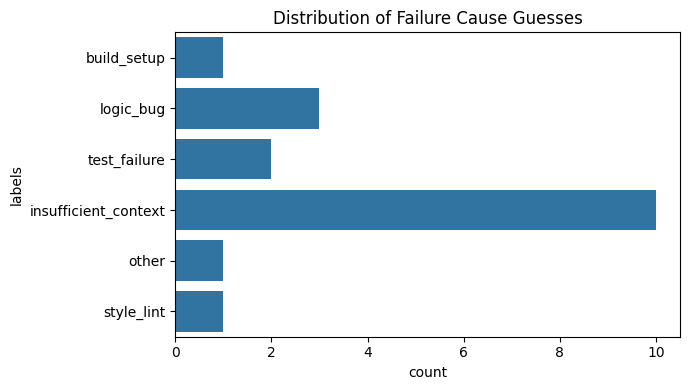

In [ ]:
# inital analysis
import ast, seaborn as sns, matplotlib.pyplot as plt

df = pd.read_csv(RESULTS_DIR / "validated_llm_outputs.csv")
pull_failed = pd.read_csv(RESULTS_DIR / "failed_prs.csv")
repo = pd.read_parquet(DATA_DIR / "repository.parquet")

merged = pull_failed.merge(df, on = "id", how = "left")
merged = merged.merge(repo[["id","language"]], left_on = "repo_id", right_on = "id", suffixes = ("", "_repo"))
merged = merged.drop(columns = ["id_repo"])  # <-- Add this line

merged["labels"] = merged["labels"].apply(lambda x: ast.literal_eval(x) if isinstance(x,str) else [])
merged_ex = merged.explode("labels").reset_index(drop = True)

plt.figure(figsize = (7,4))
sns.countplot(y = "labels", data = merged_ex)
plt.title("Distribution of Failure Cause Guesses")
plt.tight_layout()
plt.show()

In [8]:
# language across labels
cross = pd.crosstab(merged_ex["language"], merged_ex["labels"])
cross.sort_index().to_csv(RESULTS_DIR / "language_label_matrix.csv")
cross.head(10)

labels,build_setup,insufficient_context,logic_bug,other,style_lint,test_failure
language,,,,,,
Go,0,0,0,1,1,0
JavaScript,0,1,0,0,0,0
PHP,0,1,0,0,0,0
Python,0,1,0,0,0,0
Rust,0,1,1,0,0,0
Shell,0,1,0,0,0,0
TypeScript,1,5,2,0,0,2
